In [2]:
# === Cell 0: Imports, paths, config ===
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

# skimage features
from skimage.feature import hog, local_binary_pattern
from skimage.feature import graycomatrix, graycoprops

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    average_precision_score, confusion_matrix, roc_curve, precision_recall_curve
)

# --- Project base (reuse your existing) ---
BASE = Path(r"c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project")

# --- Data paths (reuse) ---
DATA = BASE / "data"
PROC_DIR = DATA / "processed_images"
LABELS_CSV = DATA / "labels.csv"
SPLITS_DIR = DATA / "splits"

# --- NEW: Texture variant outputs ---
FEAT_TEX_DIR    = DATA / "features_texture"         # npy feature arrays
MODELS_TEX_DIR  = BASE / "models_texture"           # model pkl
RESULTS_TEX_DIR = BASE / "results_texture"          # predictions + highlighted_images + metrics

(MODELS_TEX_DIR).mkdir(parents=True, exist_ok=True)
(FEAT_TEX_DIR).mkdir(parents=True, exist_ok=True)
(RESULTS_TEX_DIR / "highlighted_images").mkdir(parents=True, exist_ok=True)
(RESULTS_TEX_DIR / "models").mkdir(parents=True, exist_ok=True)

# --- Image / grid config (must match training) ---
IMG_W, IMG_H   = 800, 600
CELL_W, CELL_H = IMG_W // 8, IMG_H // 8  # 100x75

# --- Feature configs (reuse) ---
HIST_BINS = 16
HOG_PARAMS = dict(
    orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2),
    block_norm='L2-Hys', feature_vector=True
)

# --- Texture configs ---
# GLCM: 4 angles, 1 distance; props -> 6 * 4 = 24 dims
GLCM_DISTANCES = [1]
GLCM_ANGLES    = [0, np.pi/4, np.pi/2, 3*np.pi/4]
GLCM_PROPS     = ['contrast','dissimilarity','homogeneity','energy','correlation','ASM']

# LBP: uniform P=8, R=1 -> P+2 bins ≈ 10 dims
LBP_P, LBP_R   = 8, 1

# Gabor: 4 orientations x 3 sigmas; (mean,std) -> 24 dims
GABOR_THETAS   = [0, np.pi/4, np.pi/2, 3*np.pi/4]
GABOR_SIGMAS   = [1.0, 2.0, 3.0]

# Inference threshold (will keep 0.5 unless you do sweep)
THRESH = 0.5

print("Ready. Texture outputs ->", FEAT_TEX_DIR, MODELS_TEX_DIR, RESULTS_TEX_DIR, sep="\n")


Ready. Texture outputs ->
c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\data\features_texture
c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\models_texture
c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\results_texture


In [3]:
# === Cell 1: Load labels + splits ===
labels = pd.read_csv(LABELS_CSV)

# Normalize filename column to 'image'
if "image" not in labels.columns:
    cands = [c for c in labels.columns if c.lower() in
             ["imagefilename","image_file_name","filename","image","image_name","file","file_name"]]
    if not cands:
        raise ValueError("Filename column not found in labels.csv")
    labels = labels.rename(columns={cands[0]: "image"})

cell_cols = [f"c{i:02d}" for i in range(1,65)]
missing = [c for c in cell_cols if c not in labels.columns]
if missing:
    raise ValueError(f"labels.csv missing columns (first few): {missing[:5]}")

train_imgs = pd.read_csv(SPLITS_DIR / "train_images.csv", header=None)[0].tolist()
val_imgs   = pd.read_csv(SPLITS_DIR / "val_images.csv",   header=None)[0].tolist()
test_imgs  = pd.read_csv(SPLITS_DIR / "test_images.csv",  header=None)[0].tolist()

print(f"Split sizes: train={len(train_imgs)}, val={len(val_imgs)}, test={len(test_imgs)}")


Split sizes: train=383, val=21, test=22


In [4]:
# === Cell 2: Feature functions (ColorHist + HOG + Texture: GLCM, LBP, Gabor) ===

def _to_bgr(img):
    if img is None: return None
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    return img

def _ensure_gray(img):
    if img.ndim == 2:
        return img
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ----- Color hist (RGB + HSV) -> 96 dims with 16 bins -----
def color_hist_feats(bgr, bins=HIST_BINS):
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    feats = []
    for space in (rgb, hsv):
        for ch in range(3):
            h, _ = np.histogram(space[:,:,ch], bins=bins, range=(0,255), density=True)
            feats.append(h.astype(np.float32))
    return np.concatenate(feats)

# ----- HOG on grayscale -----
def hog_feats(bgr, hog_params=HOG_PARAMS):
    gray = _ensure_gray(bgr)
    h = hog(gray, **hog_params)
    return h.astype(np.float32)

# ----- GLCM (24 dims) -----
def glcm_feats(gray):
    gray8 = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    g = graycomatrix(gray8, GLCM_DISTANCES, GLCM_ANGLES, 256, symmetric=True, normed=True)
    feats = [graycoprops(g, p).ravel() for p in GLCM_PROPS]
    return np.concatenate(feats).astype(np.float32)

# ----- LBP (uniform) (≈10 dims) -----
def lbp_feats(gray, P=LBP_P, R=LBP_R):
    lbp = local_binary_pattern(gray, P, R, method='uniform')
    n_bins = P + 2
    h, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
    return h.astype(np.float32)

# ----- Gabor (24 dims) -----
def gabor_feats(gray):
    feats = []
    for th in GABOR_THETAS:
        for sg in GABOR_SIGMAS:
            k = cv2.getGaborKernel((9,9), sg, th, 8.0, 0.5, 0, ktype=cv2.CV_32F)
            f = cv2.filter2D(gray, cv2.CV_32F, k)
            feats += [float(f.mean()), float(f.std(ddof=1))]
    return np.array(feats, dtype=np.float32)

# ----- Unified extractor -----
def extract_features_texture(cell_bgr):
    bgr  = _to_bgr(cell_bgr)
    gray = _ensure_gray(bgr)
    c_h  = color_hist_feats(bgr)              # 96
    h    = hog_feats(bgr)                     # ~hundreds
    gcm  = glcm_feats(gray)                   # 24
    lbp  = lbp_feats(gray)                    # ~10
    gab  = gabor_feats(gray)                  # 24
    return np.concatenate([c_h, h, gcm, lbp, gab]).astype(np.float32)


In [5]:
# === Cell 3: 8x8 grid slicing ===
def slice_cells(img):
    h, w = img.shape[:2]
    if (w, h) != (IMG_W, IMG_H):
        raise ValueError(f"Processed image must be {IMG_W}x{IMG_H}, got {w}x{h}")
    cells = []
    for r in range(8):
        for c in range(8):
            y0, y1 = r * CELL_H, (r + 1) * CELL_H
            x0, x1 = c * CELL_W, (c + 1) * CELL_W
            cells.append(img[y0:y1, x0:x1])
    return cells


In [6]:
def build_dataset(image_list, labels_df):
    X, y = [], []
    for img_name in tqdm(image_list):
        img_path = PROC_DIR / img_name
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"[WARN] unreadable image: {img_name}")
            continue
        cells = slice_cells(img)

        row = labels_df[labels_df["image"] == img_name]
        if row.empty:
            print(f"[WARN] no labels for {img_name}; skipping")
            continue
        row = row.iloc[0]
        cell_labels = row[[f"c{i:02d}" for i in range(1,65)]].to_numpy(dtype=int)

        for cell_img, lab in zip(cells, cell_labels):
            feats = extract_features_texture(cell_img)
            X.append(feats); y.append(lab)
    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)
    return X, y


In [7]:
# === Cell 4: Build dataset (texture features) and save ===
def build_dataset(image_list, labels_df):
    X, y = [], []
    for img_name in tqdm(image_list):
        img_path = PROC_DIR / img_name
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"[WARN] unreadable image: {img_name}")
            continue
        cells = slice_cells(img)

        row = labels_df[labels_df["image"] == img_name]
        if row.empty:
            print(f"[WARN] no labels for {img_name}; skipping")
            continue
        row = row.iloc[0]
        cell_labels = row[[f"c{i:02d}" for i in range(1,65)]].to_numpy(dtype=int)

        for cell_img, lab in zip(cells, cell_labels):
            feats = extract_features_texture(cell_img)
            X.append(feats); y.append(lab)
    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)
    return X, y

Xtr, ytr = build_dataset(train_imgs, labels)
Xva, yva = build_dataset(val_imgs,   labels)
Xte, yte = build_dataset(test_imgs,  labels)

np.save(FEAT_TEX_DIR / "X_train.npy", Xtr)
np.save(FEAT_TEX_DIR / "y_train.npy", ytr)
np.save(FEAT_TEX_DIR / "X_val.npy",   Xva)
np.save(FEAT_TEX_DIR / "y_val.npy",   yva)
np.save(FEAT_TEX_DIR / "X_test.npy",  Xte)
np.save(FEAT_TEX_DIR / "y_test.npy",  yte)

Xtr.shape, Xva.shape, Xte.shape, ytr.mean(), yva.mean(), yte.mean()


100%|██████████| 22/22 [01:29<00:00,  4.07s/it]


((24512, 3322),
 (1344, 3322),
 (1408, 3322),
 np.float64(0.26807278067885115),
 np.float64(0.2507440476190476),
 np.float64(0.2784090909090909))

In [8]:
# === Cell 5: Train LR and RF, pick best, save ===

def evaluate(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    out = {"acc":acc, "precision":prec, "recall":rec, "f1":f1}
    if y_proba is not None:
        try: out["roc_auc"] = roc_auc_score(y_true, y_proba)
        except: out["roc_auc"] = np.nan
        try: out["pr_auc"]  = average_precision_score(y_true, y_proba)
        except: out["pr_auc"] = np.nan
    return out

def print_report(name, m):
    print(f"{name:>8s} | Acc {m['acc']:.4f} | P {m['precision']:.4f} | R {m['recall']:.4f} | F1 {m['f1']:.4f} | ROC {m.get('roc_auc',np.nan):.4f} | PR {m.get('pr_auc',np.nan):.4f}")

# Logistic Regression (scaled)
logreg = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"))
])
logreg.fit(Xtr, ytr)
val_pred_lr = logreg.predict(Xva)
val_prob_lr = logreg.predict_proba(Xva)[:,1] if hasattr(logreg.named_steps["clf"], "predict_proba") else None
m_lr = evaluate(yva, val_pred_lr, val_prob_lr)
print_report("LogReg", m_lr)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, n_jobs=-1,
    class_weight="balanced_subsample", random_state=42
)
rf.fit(Xtr, ytr)
val_pred_rf = rf.predict(Xva)
val_prob_rf = rf.predict_proba(Xva)[:,1]
m_rf = evaluate(yva, val_pred_rf, val_prob_rf)
print_report("RandFor", m_rf)

# Pick best by F1
cands = [("logreg", logreg, m_lr, val_prob_lr), ("rf", rf, m_rf, val_prob_rf)]
best_name, best_model, best_m, best_val_proba = max(cands, key=lambda x: x[2]["f1"])
print(f"\nBest on VAL: {best_name} -> {best_m}")

# Test metrics
test_pred = best_model.predict(Xte)
if hasattr(best_model, "predict_proba"):
    test_proba = best_model.predict_proba(Xte)[:,1]
else:
    dec = best_model.decision_function(Xte)
    test_proba = (dec - dec.min())/(dec.max()-dec.min()+1e-9)
m_test = evaluate(yte, test_pred, test_proba)
print_report("TEST", m_test)

# Save model + metrics
model_path = MODELS_TEX_DIR / "final_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(best_model, f)
print("Saved:", model_path)

rows = []
for nm, mdl, m, _proba in cands:
    rows.append({"model": nm, "split": "val", **m})
rows.append({"model": best_name, "split": "test", **m_test})
pd.DataFrame(rows).to_csv(RESULTS_TEX_DIR / "models" / "metrics.csv", index=False)
print("Saved metrics to:", RESULTS_TEX_DIR / "models" / "metrics.csv")


  LogReg | Acc 0.7775 | P 0.5461 | R 0.6677 | F1 0.6008 | ROC 0.8207 | PR 0.6164
 RandFor | Acc 0.8207 | P 0.9138 | R 0.3145 | F1 0.4680 | ROC 0.9068 | PR 0.7973

Best on VAL: logreg -> {'acc': 0.7775297619047619, 'precision': 0.5461165048543689, 'recall': 0.6676557863501483, 'f1': 0.6008010680907877, 'roc_auc': 0.820658948193506, 'pr_auc': 0.6163611703203782}
    TEST | Acc 0.7337 | P 0.5172 | R 0.6531 | F1 0.5772 | ROC 0.7903 | PR 0.5988
Saved: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\models_texture\final_model.pkl
Saved metrics to: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\results_texture\models\metrics.csv


In [9]:
# === Cell 5b (self-contained): Load saved features, train LogReg/RF/SVM/(XGB), compare, save best ===
import numpy as np, pandas as pd, pickle
from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, average_precision_score,
    roc_auc_score, confusion_matrix
)

# ---- Optional: XGBoost (skip gracefully if unavailable) ----
try:
    from xgboost import XGBClassifier
    _XGB_OK = True
except Exception as e:
    print("[INFO] xgboost not available -> skipping XGBoost. Reason:", e)
    _XGB_OK = False

# ---- Ensure output dirs exist ----
(MODELS_TEX_DIR).mkdir(parents=True, exist_ok=True)
(RESULTS_TEX_DIR / "models").mkdir(parents=True, exist_ok=True)

# ---- Load saved feature arrays ----
Xtr = np.load(FEAT_TEX_DIR / "X_train.npy")
ytr = np.load(FEAT_TEX_DIR / "y_train.npy")
Xva = np.load(FEAT_TEX_DIR / "X_val.npy")
yva = np.load(FEAT_TEX_DIR / "y_val.npy")
Xte = np.load(FEAT_TEX_DIR / "X_test.npy")
yte = np.load(FEAT_TEX_DIR / "y_test.npy")

print("Shapes | Xtr", Xtr.shape, "Xva", Xva.shape, "Xte", Xte.shape)
print("PosRate | train", ytr.mean().round(4), "| val", yva.mean().round(4), "| test", yte.mean().round(4))

# ---- Helpers ----
def evaluate(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    out = {"acc": acc, "precision": prec, "recall": rec, "f1": f1}
    if y_proba is not None:
        try: out["roc_auc"] = roc_auc_score(y_true, y_proba)
        except: out["roc_auc"] = np.nan
        try: out["pr_auc"] = average_precision_score(y_true, y_proba)
        except: out["pr_auc"] = np.nan
    return out

def print_report(name, m):
    print(f"{name:>8s} | Acc {m['acc']:.4f} | P {m['precision']:.4f} | R {m['recall']:.4f} | "
          f"F1 {m['f1']:.4f} | ROC {m.get('roc_auc',np.nan):.4f} | PR {m.get('pr_auc',np.nan):.4f}")

def get_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        dec = model.decision_function(X)
        return (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)
    else:
        raise ValueError("Model has neither predict_proba nor decision_function.")

# ---- 1) Logistic Regression (scaled, balanced) ----
logreg = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"))
])
logreg.fit(Xtr, ytr)
val_pred_lr  = logreg.predict(Xva)
val_prob_lr  = get_scores(logreg, Xva)
m_lr = evaluate(yva, val_pred_lr, val_prob_lr)
print_report("LogReg", m_lr)

# ---- 2) Random Forest (balanced_subsample) ----
rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, n_jobs=-1,
    class_weight="balanced_subsample", random_state=42
)
rf.fit(Xtr, ytr)
val_pred_rf  = rf.predict(Xva)
val_prob_rf  = get_scores(rf, Xva)
m_rf = evaluate(yva, val_pred_rf, val_prob_rf)
print_report("RandFor", m_rf)

# ---- 3) SVM RBF (scaled, balanced, probability=True) ----
svm = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("clf", SVC(kernel="rbf", C=1.0, gamma="scale", class_weight="balanced", probability=True))
])
svm.fit(Xtr, ytr)
val_pred_svm = svm.predict(Xva)
val_prob_svm = get_scores(svm, Xva)
m_svm = evaluate(yva, val_pred_svm, val_prob_svm)
print_report("SVM-RBF", m_svm)

# ---- 4) XGBoost (if available) ----
models_added = []
if _XGB_OK:
    pos = int((ytr == 1).sum())
    neg = int((ytr == 0).sum())
    spw = float(neg) / max(1.0, float(pos))

    xgb = XGBClassifier(
        n_estimators=600, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        tree_method="hist", n_jobs=-1, random_state=42,
        eval_metric="logloss", scale_pos_weight=spw
    )
    xgb.fit(Xtr, ytr)
    val_pred_xgb = xgb.predict(Xva)
    val_prob_xgb = get_scores(xgb, Xva)
    m_xgb = evaluate(yva, val_pred_xgb, val_prob_xgb)
    print_report("XGBoost", m_xgb)
    models_added.append(("xgb", xgb, m_xgb, val_prob_xgb))

# ---- Compare all on VAL by F1 ----
cands_all = [
    ("logreg", logreg, m_lr,  val_prob_lr),
    ("rf",     rf,     m_rf,  val_prob_rf),
    ("svm",    svm,    m_svm, val_prob_svm),
]
cands_all.extend(models_added)  # add xgb if available

best_name_all, best_model_all, best_m_all, best_val_proba_all = max(cands_all, key=lambda x: x[2]["f1"])
print(f"\n[ALL MODELS] Best on VAL: {best_name_all} -> {best_m_all}")

# ---- Evaluate chosen best on TEST ----
test_pred_all  = best_model_all.predict(Xte)
test_proba_all = get_scores(best_model_all, Xte)
m_test_all = evaluate(yte, test_pred_all, test_proba_all)
print_report("TEST(*)", m_test_all)

# ---- Save the new best-of-4 model + metrics table ----
model_all_path = MODELS_TEX_DIR / "final_model_all.pkl"
with open(model_all_path, "wb") as f:
    pickle.dump(best_model_all, f)
print("Saved best-of-4 model to:", model_all_path)

rows_all = []
for nm, mdl, m, proba in cands_all:
    rows_all.append({"model": nm, "split": "val", **m})
rows_all.append({"model": best_name_all, "split": "test", **m_test_all})

cmp_path = RESULTS_TEX_DIR / "models" / "metrics_all.csv"
pd.DataFrame(rows_all).to_csv(cmp_path, index=False)
print("Saved all-models comparison metrics to:", cmp_path)


Shapes | Xtr (24512, 3322) Xva (1344, 3322) Xte (1408, 3322)
PosRate | train 0.2681 | val 0.2507 | test 0.2784
  LogReg | Acc 0.7775 | P 0.5461 | R 0.6677 | F1 0.6008 | ROC 0.8207 | PR 0.6164
 RandFor | Acc 0.8207 | P 0.9138 | R 0.3145 | F1 0.4680 | ROC 0.9068 | PR 0.7973
 SVM-RBF | Acc 0.8326 | P 0.6573 | R 0.6944 | F1 0.6753 | ROC 0.8866 | PR 0.7464
 XGBoost | Acc 0.8951 | P 0.8161 | R 0.7507 | F1 0.7821 | ROC 0.9379 | PR 0.8541

[ALL MODELS] Best on VAL: xgb -> {'acc': 0.8950892857142857, 'precision': 0.8161290322580645, 'recall': 0.7507418397626113, 'f1': 0.7820710973724884, 'roc_auc': 0.9378828909797589, 'pr_auc': 0.8541017528705438}
 TEST(*) | Acc 0.8175 | P 0.6829 | R 0.6429 | F1 0.6623 | ROC 0.8786 | PR 0.7495
Saved best-of-4 model to: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\models_texture\final_model_all.pkl
Saved all-models comparison metrics to: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\results_texture

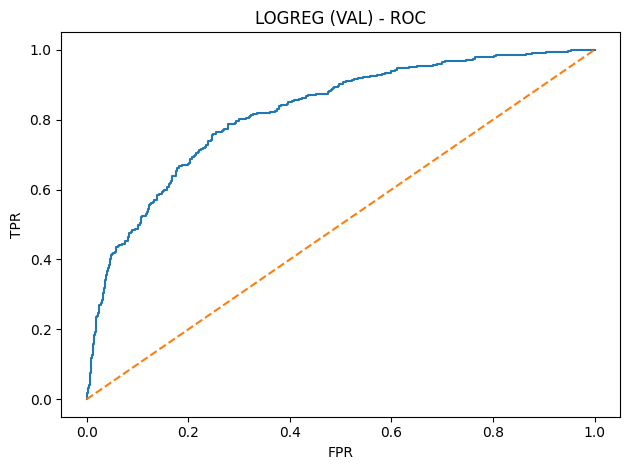

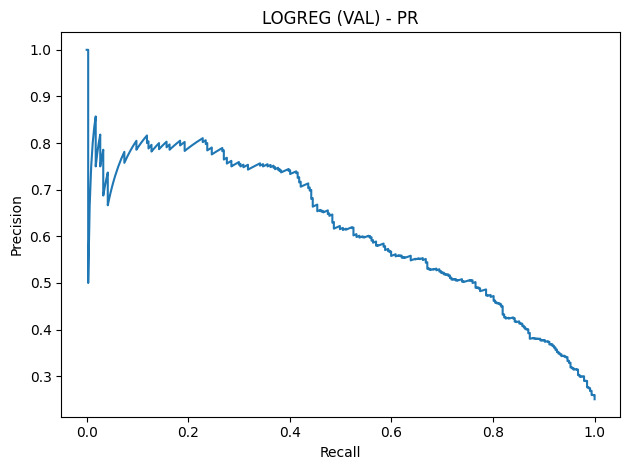

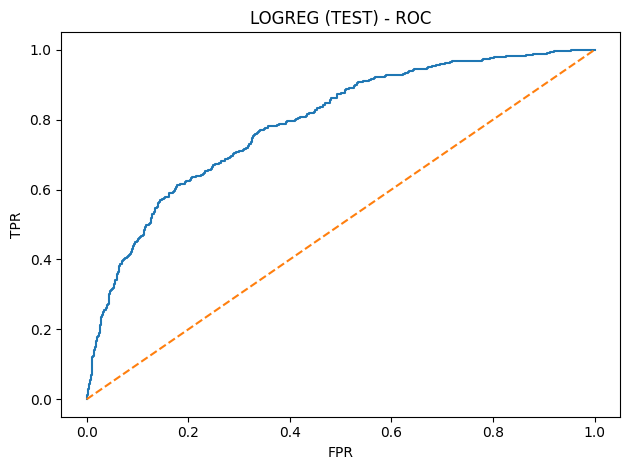

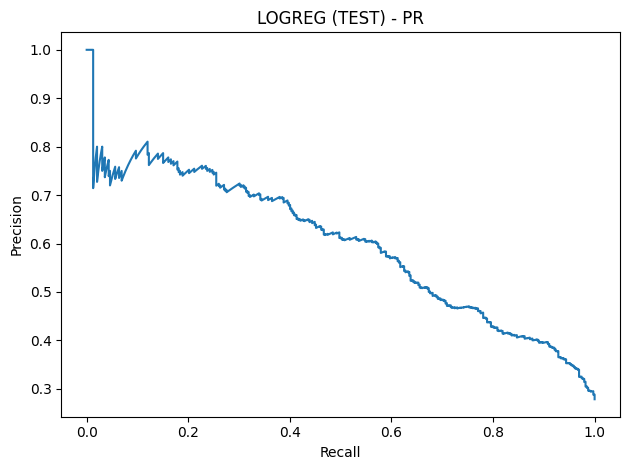

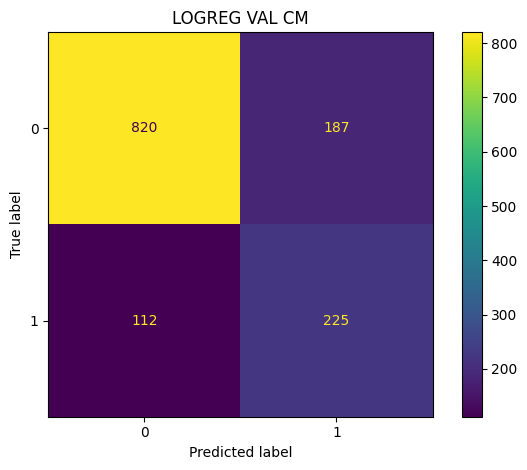

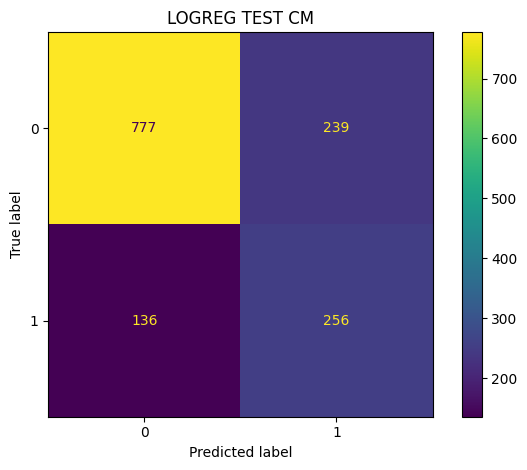

In [10]:
# === Cell 6: Curves & confusion matrices (optional) ===
def plot_curves(y_true, y_proba, title_prefix):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} - ROC"); plt.tight_layout(); plt.show()

    p, r, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(); plt.plot(r, p)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title_prefix} - PR"); plt.tight_layout(); plt.show()

from sklearn.metrics import ConfusionMatrixDisplay
if best_val_proba is not None:
    plot_curves(yva, best_val_proba, f"{best_name.upper()} (VAL)")
    plot_curves(yte, test_proba, f"{best_name.upper()} (TEST)")

disp = ConfusionMatrixDisplay(confusion_matrix(yva, best_model.predict(Xva)))
disp.plot(); plt.title(f"{best_name.upper()} VAL CM"); plt.tight_layout(); plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix(yte, best_model.predict(Xte)))
disp.plot(); plt.title(f"{best_name.upper()} TEST CM"); plt.tight_layout(); plt.show()


In [11]:
# === Cell 7 (REPLACEMENT): Batch inference (texture model) ONLY for images in labels.csv ===
PRED_CSV  = RESULTS_TEX_DIR / "predictions.csv"
HILITE_DIR = RESULTS_TEX_DIR / "highlighted_images"

def draw_grid(img, preds, thickness=2):
    out = img.copy()
    k = 0
    for r in range(8):
        for c in range(8):
            y0, y1 = r * CELL_H, (r + 1) * CELL_H
            x0, x1 = c * CELL_W, (c + 1) * CELL_W
            if preds[k] == 1:
                cv2.rectangle(out, (x0, y0), (x1, y1), (0,255,0), thickness)
            k += 1
    return out

# --- Use ONLY the filenames from labels.csv ---
labels_df = labels.copy()
if "image" not in labels_df.columns:
    # try to normalize filename column
    cands = [c for c in labels_df.columns if c.lower() in
             ["imagefilename","image_file_name","filename","image","image_name","file","file_name"]]
    if not cands:
        raise ValueError("Couldn't find an image filename column in labels.csv.")
    labels_df = labels_df.rename(columns={cands[0]: "image"})

# Build the exact list of processed files to run
valid_exts = {".jpg", ".jpeg", ".png", ".bmp"}
requested = labels_df["image"].astype(str).tolist()
img_paths = []
skipped_missing = 0
skipped_ext = 0

for name in requested:
    p = PROC_DIR / name
    if not p.exists():
        skipped_missing += 1
        continue
    if p.suffix.lower() not in valid_exts:
        skipped_ext += 1
        continue
    img_paths.append(p)

print(f"Total in labels.csv: {len(requested)}")
print(f"To run (exist & valid ext): {len(img_paths)}")
if skipped_missing:
    print(f"Skipping (missing in processed_images): {skipped_missing}")
if skipped_ext:
    print(f"Skipping (unsupported extension): {skipped_ext}")

# --- Run inference just on these files ---
rows = []
for img_path in img_paths:
    img = cv2.imread(str(img_path))
    if img is None or img.shape[:2] != (IMG_H, IMG_W):
        print(f"[SKIP] {img_path.name} unreadable or wrong size")
        continue

    # slice -> features
    cells = slice_cells(img)
    X = np.vstack([extract_features_texture(c) for c in cells])

    # proba
    if hasattr(best_model, "predict_proba"):
        proba = best_model.predict_proba(X)[:, 1]
    else:
        dec = best_model.decision_function(X)
        proba = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)

    preds = (proba >= THRESH).astype(int)

    # overlay
    overlay = draw_grid(img, preds)
    cv2.imwrite(str(HILITE_DIR / img_path.name), overlay)

    # csv row
    row = {"ImageFileName": img_path.name}
    for i, v in enumerate(preds, start=1):
        row[f"c{i:02d}"] = int(v)
    rows.append(row)

# write predictions
pred_df = pd.DataFrame(rows, columns=["ImageFileName"] + [f"c{i:02d}" for i in range(1, 65)])
pred_df.to_csv(PRED_CSV, index=False)
print(f"Wrote {len(pred_df)} rows to {PRED_CSV}")
print(f"Highlighted images -> {HILITE_DIR}")


Total in labels.csv: 426
To run (exist & valid ext): 426
Wrote 426 rows to c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\results_texture\predictions.csv
Highlighted images -> c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\results_texture\highlighted_images


Selected images:
IMG_4165.JPG
IMG_4198.JPG
IMG_4190.JPG
IMG_20250524_140427028.jpg
CIMG0095.JPG
CIMG0257.JPG
CIMG0108.JPG
CIMG0572.JPG
IMG_20250705_142522.jpg
IMG_20250710_100837.jpg


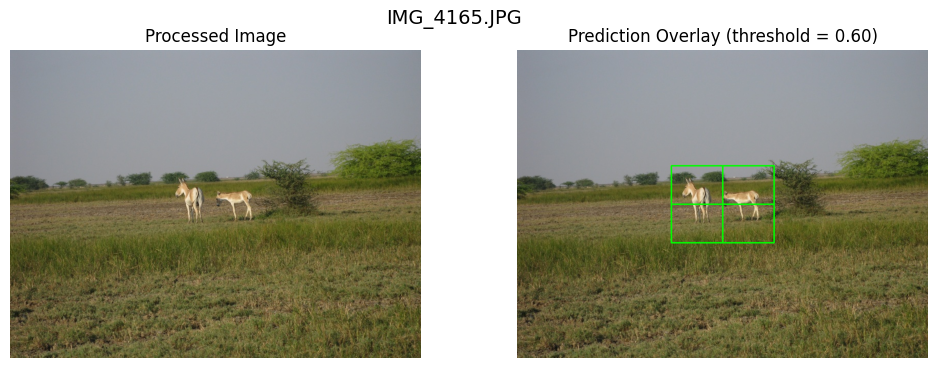

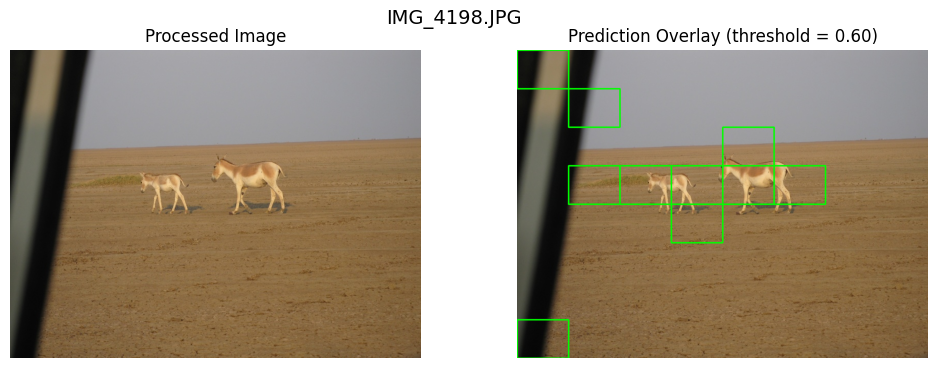

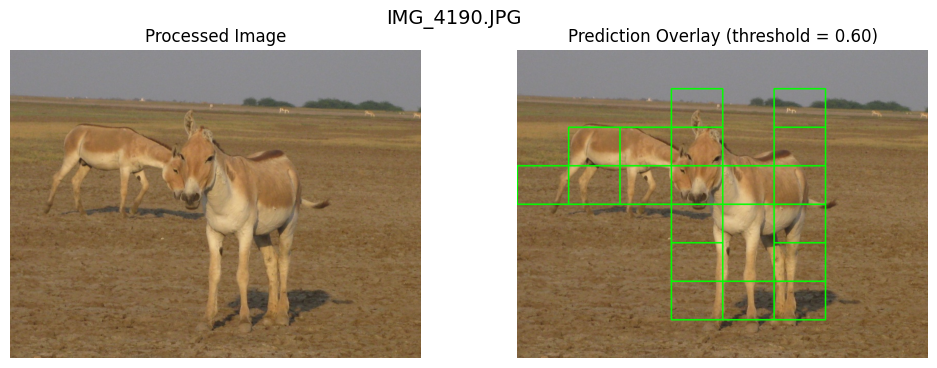

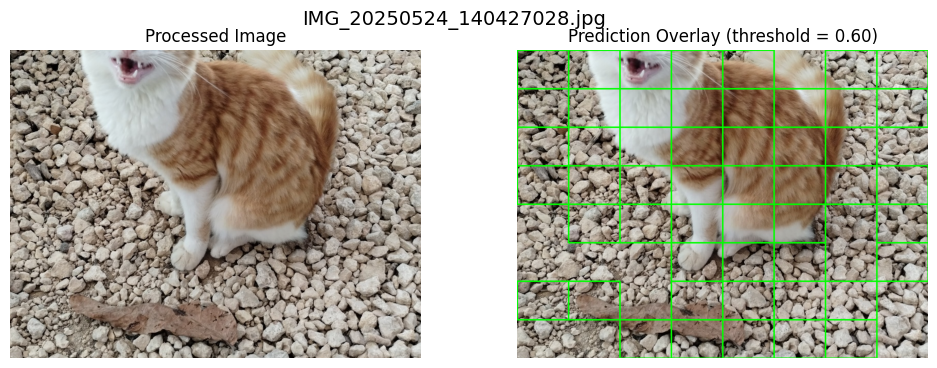

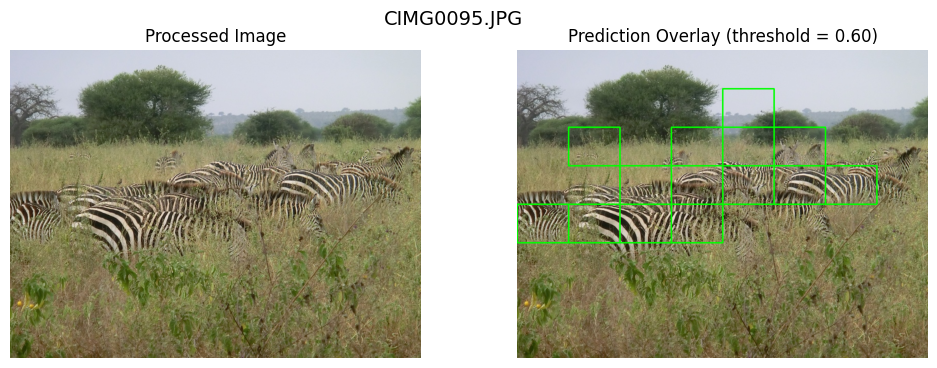

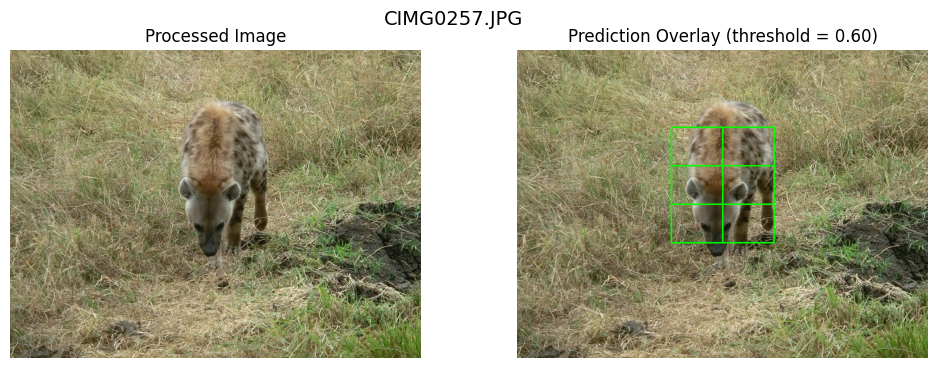

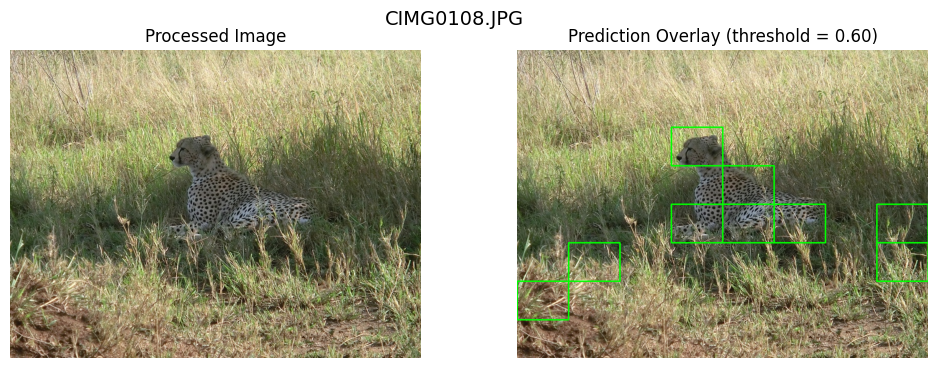

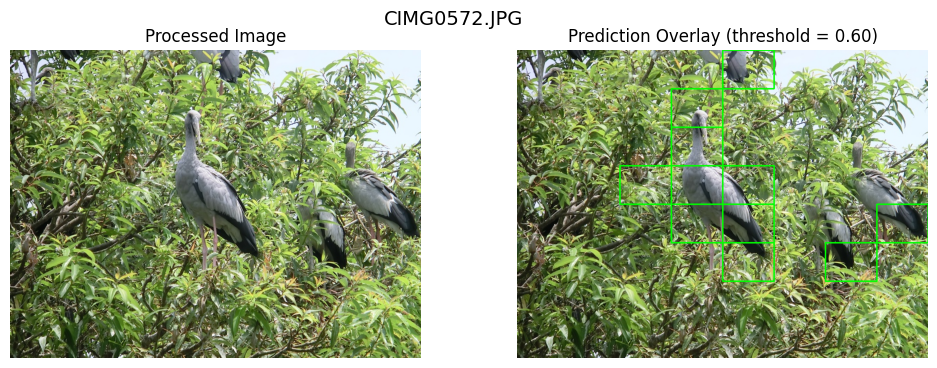

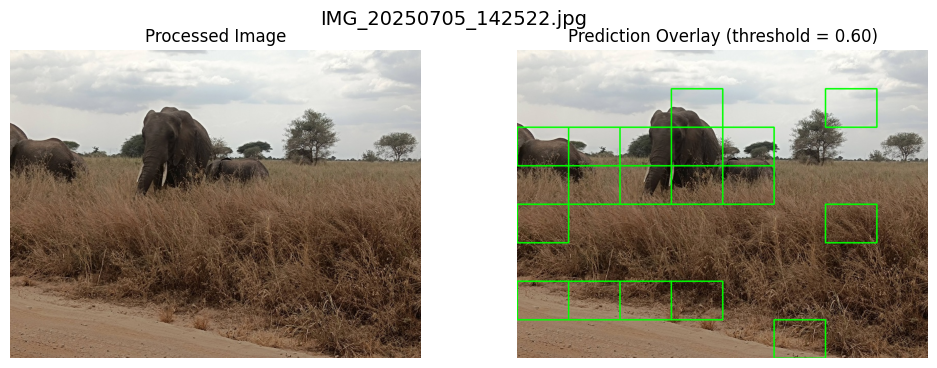

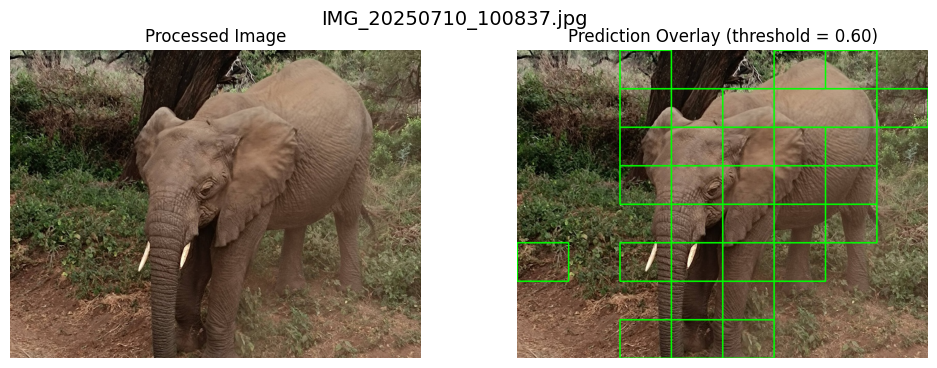

In [12]:
# === Quick Check: Run on 10 random processed images from labels.csv (no save) ===
import random
import matplotlib.pyplot as plt

# pick 10 random image names
random_imgs = random.sample(requested, min(10, len(requested)))

print("Selected images:")
print("\n".join(random_imgs))

THRESH = 0.6

for name in random_imgs:
    img_path = PROC_DIR / name
    if not img_path.exists():
        print(f"[MISSING] {name}, skipping")
        continue

    img = cv2.imread(str(img_path))
    if img is None or img.shape[:2] != (IMG_H, IMG_W):
        print(f"[SKIP] {name} (unreadable or wrong size)")
        continue

    # slice & extract features
    cells = slice_cells(img)
    X = np.vstack([extract_features_texture(c) for c in cells])

    # predict
    if hasattr(best_model, "predict_proba"):
        proba = best_model.predict_proba(X)[:, 1]
    else:
        dec = best_model.decision_function(X)
        proba = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)

    preds = (proba >= THRESH).astype(int)

    # overlay (no save)
    overlay = draw_grid(img, preds)

    # show side-by-side
    plt.figure(figsize=(12,4))
    plt.suptitle(name, fontsize=14)

    plt.subplot(1,2,1)
    plt.title("Processed Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Prediction Overlay (threshold = {:.2f})".format(THRESH))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()
